## Art Dating

#### Students
- Zhenbang Chen
- Zhenjia Chen

### Setup

Importing packages and dependencies.  Load dataset for categorization.

In [2]:
import os
import copy
from PIL import Image
rootpath = "."

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm.auto import tqdm
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2
Using the GPU!


### Model Initialization

In [5]:
def initialize_model(num_classes, resume_from=None):
    
    if resume_from:
        model_ft = models.resnet50(pretrained=False)
#         model_ft = models.vgg16_bn(pretrained=False)
        
        in_features = model_ft.fc.in_features
        model_ft.fc = nn.Linear(in_features, num_classes)
#         in_features = model_ft.classifier[6].in_features
#         model_ft.classifier[6] = nn.Linear(in_features, num_classes)
        
        model_ft.load_state_dict(torch.load(resume_from))
        
        return model_ft
    else:
        # Model (nn.Module) to return
        model_ft = models.resnet50(pretrained=True)
#         model_ft = models.vgg16_bn(pretrained=True)

        in_features = model_ft.fc.in_features
        model_ft.fc = nn.Linear(in_features, num_classes)
#         in_features = model_ft.classifier[6].in_features
#         model_ft.classifier[6] = nn.Linear(in_features, num_classes)

        return model_ft

### Tests

In [6]:
# Transform to apply to the data
# transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))
# ])

# Transform to apply to the data for use with pretrained ResNet model
transform = torchvision.transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
# Get training data from directory
art_train = torchvision.datasets.ImageFolder(root="./data/art_culture_train",
                                                 transform=transform)

# Get validation data from directory
art_val = torchvision.datasets.ImageFolder(root="./data/art_culture_val",
                                               transform=transform)

# Get testing data from directory
art_test = torchvision.datasets.ImageFolder(root="./data/art_culture_test",
                                               transform=transform)

In [8]:
# Create random sampler
random_sampler = torch.utils.data.RandomSampler(data_source=art_train,
                                                replacement=True,
                                                num_samples=int(len(art_train)/10))

# Create batched dataloader
art_train_loader = torch.utils.data.DataLoader(dataset=art_train,
                                                   batch_size=8,
                                                   shuffle=True,
                                                   num_workers=4,
                                                   pin_memory=True)

# art_train_loader = torch.utils.data.DataLoader(dataset=art_train,
#                                                    batch_size=8,
#                                                    sampler=random_sampler,
#                                                    shuffle=False,
#                                                    num_workers=4,
#                                                    pin_memory=True)

art_val_loader = torch.utils.data.DataLoader(dataset=art_val,
                                                 batch_size=8,
                                                 shuffle=False,
                                                 num_workers=4,
                                                 pin_memory=True)

art_test_loader = torch.utils.data.DataLoader(dataset=art_test,
                                                 batch_size=8,
                                                 shuffle=False,
                                                 num_workers=4,
                                                 pin_memory=True)

### Initialization and Methods

In [9]:
# Initialize model
# model = torchvision.models.resnet18(pretrained=False)
# model = torchvision.models.resnet50(pretrained=True)

# Set number of output classes
# model.conv1 = nn.Conv2d(in_channels=3,
#                         out_channels=64,
#                         kernel_size=(7,7),
#                         stride=(2,2),
#                         padding=(3,3),
#                         bias=False)

# in_features = model.fc.in_features
# out_features = 11
# model.fc = nn.Linear(in_features, out_features)

# model = model.to(device)

model = initialize_model(num_classes=11).to(device)

In [10]:
# Modify Network

def transfer_learning():
    in_features = model.fc.in_features
    num_classes = model.fc.out_features
    hidden_size = 512

    dense_network = nn.Sequential(
        nn.Linear(in_features, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, num_classes)
    ).to(device)

    model.fc = dense_network
    
# transfer_learning()
    
# for index, child in enumerate(model.children()):
#     if index != 9:
#         for param in child.parameters():
#             param.requires_grad = False

# print(model)

In [11]:
# Training method
def train(net, optim, criterion,train_loader):
    net.train()
    for image_cpu, label_cpu in tqdm(train_loader):
        # Move image and label to GPU
        image = image_cpu.to(device)
        label = label_cpu.to(device)
        
        # Clear gradient
        optim.zero_grad()
        
        # Forward through the network
        output = net(image)
        
        # Loss and gradient
        loss = criterion(output, label)
        loss.backward()
        
        # Update paramters
        optim.step()

In [12]:
# Evaluation method
def evaluate(net, val_loader, top_n=1):
    total = 0
    correct = 0
    net.eval()
    
    for image_cpu, label_cpu in tqdm(val_loader):
        # Move image and label to GPU
        image = image_cpu.to(device)
        label = label_cpu.to(device)
        tiled_labels = torch.stack([label for _ in range(top_n)], dim=1) 

        
        # Don't track gradients for performance in evaluation
        with torch.no_grad():
            # Get prediction with forward pass
#             prediction = net(image).argmax(dim=-1)
            
            # Get the indices of the top_n predictions
            prediction = net(image).topk(k=top_n, dim=-1)[1]
            
            # Total number in batch
            total += image.size(0)
            
            # Number correct in batch
#             correct += (prediction == label).sum().item()
            # Number correct in batch
            correct += (prediction == tiled_labels).sum().item()
            
    return correct/total

In [13]:
# Validation method
def validate(net, optim, criterion, val_loader):
    total = 0
    running_loss = 0
    correct = 0
    net.eval()
    
    for image_cpu, label_cpu in tqdm(val_loader):
        # Move image and label to GPU
        image = image_cpu.to(device)
        label = label_cpu.to(device)
        
        # Clear gradient
        optim.zero_grad()
        
        # Don't track gradients for performance in validation
        with torch.no_grad():
            # Forward through the network
            output = net(image)
            
            # Get prediction with forward pass
            prediction = output.argmax(dim=-1)

            # Loss and gradient
            loss = criterion(output, label)
            
            # Total number in batch
            total += image.size(0)
            
            # Accumulate loss
            running_loss += loss.item()
            
            # Number correct in batch
            correct += (prediction == label).sum().item()
            
    return running_loss/total, correct/total

### Training

In [ ]:
# Create optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Create criterion
criterion = torch.nn.CrossEntropyLoss()

# Create scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=0.1)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
#                                                  mode="min",
#                                                  factor=0.2,
#                                                  patience=1,
#                                                  verbose=True,
#                                                  threshold=0.01)

In [ ]:
# Start training
num_epochs = 12

print("start")

best_state_dict = {}
best_val_acc = 0
for epoch in range(num_epochs):
    print("Epoch {}".format(epoch))
#     val_acc = evaluate(model, art_val_loader) * 100
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_state_dict = copy.deepcopy(model.state_dict())
    
    train(model, optimizer, criterion, art_train_loader)
    val_loss, val_acc = validate(model, optimizer, criterion, art_val_loader)
    scheduler.step(val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = copy.deepcopy(model.state_dict())
    
    print("Val Loss - Epoch {}: {}".format(epoch, val_loss))
    print("Val Acc - Epoch {}: {}%".format(epoch, val_acc))
    
#     if epoch % 4 == 0 and epoch != 0:
#         torch.save(best_state_dict, "./models/art_culture_temp_epoch" + str(epoch))
    
print("Done! {}%".format(evaluate(model, art_val_loader) * 100))

In [ ]:
# Save model
torch.save(best_state_dict, "./models/art_culture_vgg16bn_steplr0001_step3_gamma01_epoch12")

### Testing

In [169]:
# Load the model to test
model = initialize_model(num_classes=11,
                         resume_from="./models/art_culture_platlr0001_fac02_pat1_thres001_epoch30").to(device)

# model = initialize_model(num_classes=11).to(device)
# transfer_learning()
# model.load_state_dict(torch.load("./models/art_culture_transfer_epoch30"))

test_acc = evaluate(net=model, val_loader=art_test_loader, top_n=3)
print("Done!", test_acc)


Done! 0.918429003021148


### Visualize Activations

In [15]:
import cv2
from io import BytesIO
from IPython.display import clear_output, Image, display
import PIL.Image

In [137]:
def generate_featuremap_unit(resnet,unit_id,im_input):
    #Extract activation from model
    #TODO: remove the last 2 layers of resnet 
    model_cut = nn.Sequential(*(list(resnet.children())[:-2]))

    # Mark the model as being used for inference
    model_cut.eval()
    # Crop the image
    im = transform(im_input).to(device)
    # Place the image into a batch of size 1, and use the model to get an intermediate representation
    
    with torch.no_grad():
        out = model_cut(im.unsqueeze(0))
        # Print the shape of our representation
        print(out.size())
        # Extract the only result from this batch, and take just the `unit_id`th channel
    #     out_final = out.squeeze()[unit_id]

        out_sums = out.squeeze().sum(dim=(1,2), keepdim=True)
        out_sums = torch.where(out_sums != 0, out_sums, torch.ones(out_sums.size()).to(device))
        out_final = (out.squeeze() / 1).sum(dim=0)

    #     out_final = out.squeeze().sum(dim=0)

    #     print(out_final.size())
        print(out_final)

        # Return this channel
        return out_final

In [145]:
def visualize_featuremap(im_input,feature_map,alpha=.4):
    # Normalize to [0..1], with a little leeway (0.9999) in case feature_map has 0 range
    feature_map = feature_map/(feature_map.max()+1e-10)
    # Convert to numpy (detach() just seperates a tensor from the gradient)
    feat_numpy = feature_map.detach().cpu().numpy()
    # Resize the feature map to our original image size (our strided conv layers reduce the size of the image)
    feat_numpy = cv2.resize(feat_numpy,(im_input.shape[1],im_input.shape[0]))
    # Invert to make the heatmap look more natural
    map_t = 1-feat_numpy
    # Add an extra dimension to make this a [H,W,C=1] image 
    feat_numpy = np.expand_dims(feat_numpy, axis=2)
    
    # Convert to image (UINT8 from 0-255)
    map_t = 255*map_t
    map_t = map_t.astype(np.uint8)
    # Use a color map to change this from BW to a nice color
    map_t = cv2.applyColorMap(map_t, cv2.COLORMAP_JET)
    # Combine the heatmap with the original image so you can see which section of the image is activated
    im_final = np.multiply((alpha*im_input + (1-alpha)*map_t), feat_numpy) + np.multiply(im_input, 1-feat_numpy)
    # Return final visualization
    return im_final

In [18]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

torch.Size([1, 2048, 7, 7])
tensor([[ 612.1138,  488.4475,  404.6306,  237.8587,  224.0370,  296.4944,
          393.4713],
        [ 932.9291,  776.7737,  544.0195,  324.2351,  315.1618,  449.3172,
          522.7351],
        [ 944.7315,  831.6008,  559.4662,  503.8557,  501.3406,  557.8036,
          546.6239],
        [1080.4880, 1034.0703,  882.6573,  981.6846, 1062.5647,  971.6472,
          722.0065],
        [1076.6140, 1272.3844, 1340.1459, 1491.9670, 1371.8928, 1474.0098,
         1242.7021],
        [ 986.7207, 1314.5459, 1504.9576, 1698.7623, 1648.4434, 1728.7341,
         1452.1600],
        [ 759.0619, 1069.2898, 1237.6929, 1795.9281, 1826.7205, 1621.8315,
         1403.0513]], device='cuda:0')


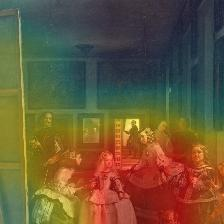

In [167]:
# img0 = load_image("test_images/american_gothic.jpg").to(device)

culture = "japanese"
image_index = "965"

img0 = PIL.Image.open("test_images/las_meninas.jpg").convert("RGB")
# img0 = PIL.Image.open("./data/art_culture_all_filtered/" + culture + "/" + str(image_index) + ".jpg").convert("RGB")

feat = generate_featuremap_unit(model,0,img0)

# # Apply transforms (resize and center crop)
img0 = img0.resize((
    int(256*img0.width/min(img0.width, img0.height)),
    int(256*img0.height/min(img0.width, img0.height)),
))
img0 = img0.crop((
    (img0.width - 224)/2,
    (img0.height - 224)/2,
    (img0.width + 224)/2,
    (img0.height + 224)/2,
))
img_numpy = np.array(img0)

im_final = visualize_featuremap(img_numpy,feat)
showarray(im_final)

### Compute Separation

In [ ]:
def compute_culture_center(culture, model):
    '''Calculates the average Euclidean center of the all image outputs for a culture using model'''
    
    # Get list of all image files in the appropriate folder
    image_files = os.listdir("data/art_culture_all_filtered/" + culture)[:]
    
    # Switch to evaulation mode
    model.eval()
    
    # Variable for accumulating outputs
    total_tensor = torch.zeros((1,11)).to(device)
    total_images = len(image_files)
    
    # Iteratively accumulate outputs in total_tensor
    for file in image_files:
        image = load_image("data/art_culture_all_filtered/" + culture + "/" + file).to(device)
        
        with torch.no_grad():
            result_vec = model(image)
            total_tensor += result_vec
            
    return total_tensor / total_images

# print(compute_culture_center("spanish", model))

In [ ]:
# Average Euclidean center of all image outputs for each culture using best model
culture_tensors = {
    "american" : torch.tensor([[ 7.0664,  1.6778, -1.8836, -0.8605, -1.1828,  0.9407, -0.0519, -1.8947, -1.8577, -0.9771, -0.6822]]),
    "british" : torch.tensor([[ 1.3715e+00,  3.6504e+00, -2.1580e+00, -2.0042e-03,  3.3697e-01, 2.0065e+00,  9.8763e-01, -2.6181e+00, -1.0272e+00, -2.6346e+00, -2.5038e-01]]),
    "chinese" : torch.tensor([[-0.6801, -1.5646,  7.2309, -1.5411, -1.5731, -0.1273, -1.0995,  0.2166, -1.4205,  2.1701, -0.9345]]),
    "dutch" : torch.tensor([[-0.7726,  0.0573, -2.4268,  3.7708,  0.8802,  1.4279,  1.2017, -3.0107, 1.2312, -3.2050,  0.4194]]),
    "flemish" : torch.tensor([[-0.5941,  0.9288, -2.2716,  1.5399,  1.8579,  1.8715,  0.8328, -2.9006, 1.2896, -2.9780,  0.3761]]),
    "french" : torch.tensor([[ 0.2759,  0.8285, -2.0896,  0.7542,  0.6249,  3.9568,  0.4689, -3.0201, 0.2730, -2.1955, -0.0474]]),
    "german" : torch.tensor([[-0.1850,  0.7377, -2.0441,  1.2382,  0.3095,  1.1902,  1.7258, -2.0748, 1.1933, -2.6024,  0.3569]]),
    "indian" : torch.tensor([[-0.6212, -2.5173,  1.3177, -2.3141, -2.8249, -1.3583, -0.5100,  7.6875, -0.5083,  0.6289,  0.6106]]),
    "italian" : torch.tensor([[-1.8449, -1.1914, -2.2632,  0.9813,  0.5290,  0.8880,  1.4288, -1.7552, 5.1137, -2.9153,  0.9664]]),
    "japanese" : torch.tensor([[ 0.1553, -2.1064,  2.4003, -2.0872, -2.0149, -0.1749, -1.4981,  0.2818, -1.4746,  8.0753, -0.9232]]),
    "spanish" : torch.tensor([[-0.6073, -0.2381, -1.3960,  0.5750,  0.0869,  1.0328,  0.6943, -0.9015, 0.9975, -2.0954,  1.6449]])
}

In [ ]:
def compute_distance_between_cultures(culture1, culture2):
    '''Computes the Euclidean distance between two culture centers'''
    return torch.dist(culture_tensors[culture1], culture_tensors[culture2]).item()

def compute_all_distances_from_culture(culture1):
    '''Computes the Eucliean distance of all cultures from the specified culture'''
    results = []
    for culture2 in culture_categories_list:
        results.append((culture2, compute_distance_between_cultures(culture1, culture2)))
    
    return [x[1] for x in results]
    
#     return sorted(results, key=lambda x: x[1])

# for pair in compute_all_distances_from_culture("american"):
#     print(pair)

In [ ]:
culture_distances = []
for culture in culture_categories_list:
    culture_distances.append(compute_all_distances_from_culture(culture))
    
for row in range(len(culture_distances)):
    # Apply function to each value
    for col in range(len(culture_distances[row])):
        if not (abs(culture_distances[row][col]) <= 0.00000001):
            culture_distances[row][col] = 1/culture_distances[row][col]**2
            
#     Normalize each row/culture
    row_sum = sum(culture_distances[row])
    for col in range(len(culture_distances[row])):
        if not (abs(culture_distances[row][col]) <= 0.00000001):
            culture_distances[row][col] = culture_distances[row][col]/row_sum
    
# print(culture_distances)

print("labels" + " " + " ".join(culture_categories_list))
for row in range(len(culture_distances)):
#     print(culture_distances[row])
    print(culture_categories_list[row] + " " + " ".join([str(x*100000) for x in culture_distances[row]]))

In [ ]:
colors = ["#ff0000", "#ff8c00", "#eaff00", "#5eff00", "#00ff2f", "#00ffbb", "#00bbff", "#002fff", "#5d00ff", "#ea00ff", "#ff0088"]

### Miscellaneous

In [19]:
culture_categories = {
    0 : "american",
    1 : "british",
    2 : "chinese",
    3 : "dutch",
    4 : "flemish",
    5 : "french",
    6 : "german",
    7 : "indian",
    8 : "italian",
    9 : "japanese",
    10 : "spanish"
}

culture_categories_list = ["american",
                           "british",
                           "chinese",
                           "dutch",
                           "flemish",
                           "french",
                           "german",
                           "indian",
                           "italian",
                           "japanese",
                           "spanish"]

C:\Users\Zhenbang\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[6.9932e-01, 1.8068e-01, 3.7430e-02, 3.2422e-02, 1.4739e-02, 1.0927e-02,
         1.0617e-02, 6.3628e-03, 5.3531e-03, 1.8292e-03, 3.2676e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
[('american',), ('dutch',), ('spanish',), ('german',), ('french',), ('italian',), ('indian',), ('british',), ('flemish',), ('chinese',), ('japanese',)]


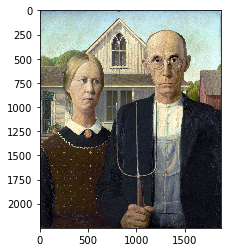

In [172]:
# Test on one specific example

# from torch.autograd import Variable
import matplotlib.pyplot as plt

def load_image(image_name):
    """Loads an image; returns a batched image tensor"""
    image = PIL.Image.open(image_name).convert("RGB")
    plt.imshow(image)
    
    image = transform(image)
    
#     plt.imshow(image.permute(1,2,0))
    
    image = image.clone().detach().requires_grad_(True)
    image = image.unsqueeze(0)
    return image


def classify_image(model, categories, image_name):
    '''Classify an image using a specified model'''
    model.eval()
    image = load_image(image_name).to(device)
    result_vec = model(image)
    
    sorted_result_vec, sorted_indices = result_vec.sort(descending=True)
    
    results = sorted_indices[0].tolist()
    probabilities = torch.nn.functional.softmax(sorted_result_vec)
    print(probabilities)
    
    return [(categories[index],) for index in results]

# model = initialize_model(num_classes=11,
#                          resume_from="./models/art_culture_platlr0001_fac02_pat1_thres001_epoch30").to(device)

culture = "spanish"
image_index = "27"

print(classify_image(model,
                     culture_categories,
                     "test_images/american_gothic.jpg"))

# print(classify_image(model,
#                      culture_categories,
#                      "./data/art_culture_test/" + culture + "/" + str(image_index) + ".jpg"))

In [ ]:
# Get testing data from directory
letters_val = torchvision.datasets.ImageFolder(root="./data/text_val",
                                               transform=transform)

letters_val_loader = torch.utils.data.DataLoader(dataset=letters_val,
                                                 batch_size=512,
                                                 shuffle=False,
                                                 num_workers=4,
                                                 pin_memory=True)

# Initialize model
model = torchvision.models.resnet18(pretrained=False)
# model = torchvision.models.resnet50(pretrained=False)

# Set number of output classes
model.conv1 = nn.Conv2d(in_channels=3,
                        out_channels=64,
                        kernel_size=(7,7),
                        stride=(2,2),
                        padding=(3,3),
                        bias=False)

in_features = model.fc.in_features
out_features = 26
model.fc = nn.Linear(in_features, out_features)

model = model.to(device)
model.load_state_dict(torch.load("./models/letter_model_lr01_gamma015_e12"))

val_acc = evaluate(model, letters_val_loader) * 100
print("Done!", val_acc)